In [1]:
# Libaries Required
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers , models
from sklearn.utils.class_weight import compute_class_weight
import cv2 
from tensorflow.keras.applications import ResNet152V2
import tensorflow as tf

C:\Users\Kavinda\AppData\Roaming\Python\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Importing dataset

In [15]:
data_path = "kaggle/input/skin-disease-dataset"
print(os.listdir(data_path))

['skin-disease-datasaet']


In [16]:
inner_path = os.path.join(data_path, "skin-disease-datasaet")
print(os.listdir(inner_path))

['train_set']


(224, 224, 3)


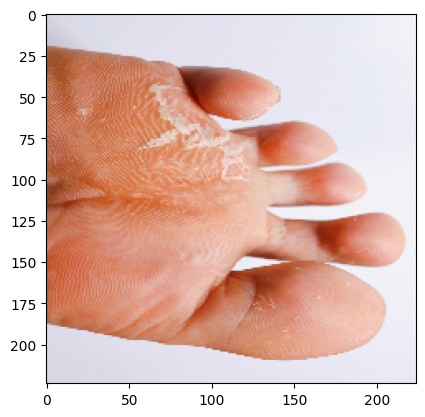

In [17]:
# Providing path to dataset
base_dir ='kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set'
image_path='kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set/FU-athlete-foot/FU-athlete-foot (1).png'

# Reading the image
img=mpimg.imread(image_path)
print(img.shape)

#display image
plt.imshow(img)
plt.axis()
plt.show()

# Preprocessing of Image data | Training Validation Split

In [18]:
img_size = 224
batch_size = 32

def resize_and_pad(img):
    desired_size = 224
    old_size = img.shape[:2]  # (height, width)

    # Compute ratio and new size
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resize the image
    img = cv2.resize(img, (new_size[1], new_size[0]))

    # Padding
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    padded_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_img / 255.0  # Normalize [0, 1]

data_gen = ImageDataGenerator(
    preprocessing_function=resize_and_pad,
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
    validation_split=0.25
)



train_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    interpolation='bilinear',
    shuffle=True
)

valid_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    interpolation='bilinear',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)
print("Class sample counts:", np.bincount(train_gen.classes))


Found 695 images belonging to 8 classes.
Found 229 images belonging to 8 classes.
Class indices: {'BA- cellulitis': 0, 'BA-impetigo': 1, 'FU-athlete-foot': 2, 'FU-nail-fungus': 3, 'FU-ringworm': 4, 'PA-cutaneous-larva-migrans': 5, 'VI-chickenpox': 6, 'VI-shingles': 7}
Class sample counts: [102  60  93  97  68  75 102  98]


# Providing weights to classes
#### Note: As image dataset is very imbalanced so we can provide predefined weights to each class which will help our neural network to classify that class.  

Class Weights: {0: np.float64(0.8517156862745098), 1: np.float64(1.4479166666666667), 2: np.float64(0.9341397849462365), 3: np.float64(0.895618556701031), 4: np.float64(1.2775735294117647), 5: np.float64(1.1583333333333334), 6: np.float64(0.8517156862745098), 7: np.float64(0.8864795918367347)}


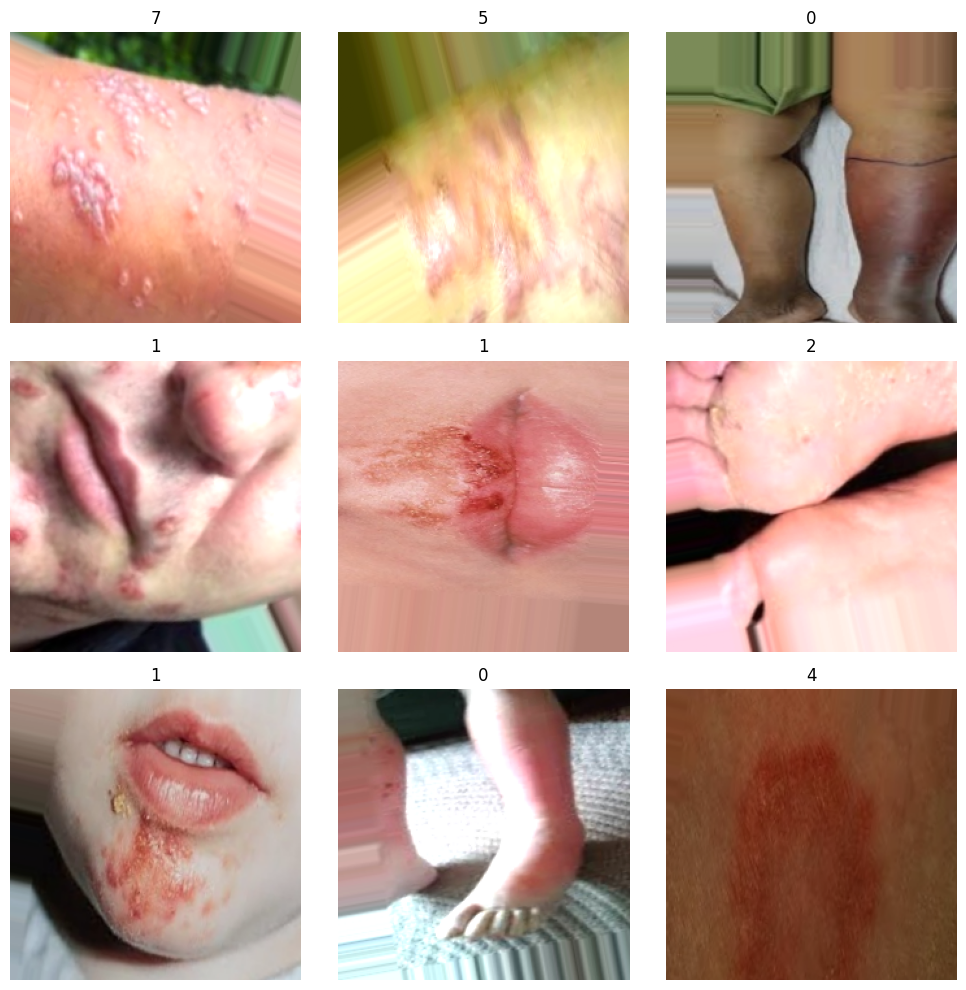

In [19]:
#  Compute Class Weights 
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Preview Images 
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(np.argmax(y_batch[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

# Transfer-learning based model (ResNet152V2) and Training of model

In [20]:
#Model Creation
base_model = ResNet152V2(include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 316s 1us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,858,248 (224.53 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [21]:
#Training the Model
history=model.fit(
    train_gen,
    epochs=25,
    validation_data=valid_gen,
    class_weight=class_weights_dict
)

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 259s 11s/step - accuracy: 0.6072 - loss: 1.2358 - val_accuracy: 0.7729 - val_loss: 0.6472
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 217s 10s/step - accuracy: 0.7942 - loss: 0.6215 - val_accuracy: 0.8079 - val_loss: 0.4602
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 219s 10s/step - accuracy: 0.8432 - loss: 0.4496 - val_accuracy: 0.8472 - val_loss: 0.4494
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 221s 10s/step - accuracy: 0.9050 - loss: 0.3288 - val_accuracy: 0.8821 - val_loss: 0.3740
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 218s 10s/step - accuracy: 0.9122 - loss: 0.2547 - val_accuracy: 0.8777 - val_loss: 0.3797
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 216s 10s/step - accuracy: 0.9367 - loss: 0.2349 - val_accuracy: 0.8777 - val_loss: 0.3819
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 217s 10s/step - accuracy: 0.9209 - loss: 0.2289 - val_accuracy: 0.8908 - val_loss: 0.3075
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 216s 10s/step - accuracy: 0.9353 - loss: 0.1942 - val_accuracy: 0.

In [22]:
print("Evaluating model........")
val_loss,val_accuracy=model.evaluate(valid_gen,steps=valid_gen.samples//batch_size)
print(f"validation accuracy:{val_accuracy*100:.2f}%")

Evaluating model........
7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.9420 - loss: 0.2223
validation accuracy:94.20%


# Evaluation of Model
### Classification Report i.e. **Accuracy,F1-Score,Precision,Recall**

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
# Get true and predicted labels
Y_true = valid_gen.classes
Y_pred = np.argmax(model.predict(valid_gen), axis=1)

# Report
print(classification_report(Y_true, Y_pred, target_names=valid_gen.class_indices.keys()))


8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 8s/step
                            precision    recall  f1-score   support

            BA- cellulitis       0.96      0.82      0.89        33
               BA-impetigo       1.00      0.90      0.95        20
           FU-athlete-foot       0.96      0.84      0.90        31
            FU-nail-fungus       0.89      0.97      0.93        32
               FU-ringworm       0.84      0.95      0.89        22
PA-cutaneous-larva-migrans       0.83      0.96      0.89        25
             VI-chickenpox       0.97      1.00      0.99        34
               VI-shingles       0.94      0.94      0.94        32

                  accuracy                           0.92       229
                 macro avg       0.92      0.92      0.92       229
              weighted avg       0.93      0.92      0.92       229



### *Classification Report seems to be quite good as f1 score, precision, recall are satisfactory and model accuracy is around 92% so considering it we can create a prediction* 

In [24]:
model.save('Skin_disease_model.h5')

# Prediction

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model("Skin_disease_model.h5")

# Class index to label mapping
class_indices = {
    'BA- cellulitis': 0,
    'BA-impetigo': 1,
    'FU-athlete-foot': 2,
    'FU-nail-fungus': 3,
    'FU-ringworm': 4,
    'PA-cutaneous-larva-migrans': 5,
    'VI-chickenpox': 6,
    'VI-shingles': 7
}

# Reverse the mapping to get label from prediction index
index_to_label = {v: k for k, v in class_indices.items()}

img_path = "/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/VI-shingles/127_VI-shingles (32).jpg"
#C:\Users\Kavinda\AIWoundOrrashDettector\kaggle\input\skin-disease-dataset\skin-disease-datasaet\test_set\VI-shingles
# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# Predict
pred = model.predict(img_array)
predicted_index = np.argmax(pred)
predicted_label = index_to_label[predicted_index]

# Show result
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_label}")
plt.show()


C:\Users\Kavinda\AppData\Roaming\Python\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/VI-shingles/127_VI-shingles (32).jpg'